# YouTube Audience Network & User Communities analysis

## Overview

This notebook presents a comprehensive analysis of YouTube's audience network and user communities using the YouNiverse dataset. The analysis consists of two main parts:

### Part 1: Video-Video Audience Network
Constructs and analyzes an audience network where **videos are nodes** and **edges represent shared commenters**. This reveals how videos connect through their audiences and identifies hub videos that bridge different content communities.

### Part 2: User Community Detection
Analyzes user behavior patterns to identify distinct communities using two complementary approaches:
- **Feature-based clustering**: K-means on user activity, diversity, and engagement features
- **Graph-based clustering**: k-NN similarity graph with Louvain community detection

### Imports

In [8]:
#### Part for Google colab #####
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Add your project folder to the Python path
import sys
import os

# CHANGE THIS PATH to match your actual folder name in Drive
PROJECT_PATH = '/content/drive/My Drive/ADA_project/'
sys.path.append(PROJECT_PATH)

# 3. Install missing libraries (Colab has networkx/pandas, but might need python-louvain)
!pip install python-louvain

# 4. Check if it works
try:
    from utils import network_builder
    print("setup successful! Modules found.")
except ImportError:
    print("Error: Could not find your modules. Check the PROJECT_PATH.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
setup successful! Modules found.


In [ ]:
# Standard Library Imports
import ast
import os
import sys
import time
from collections import Counter, defaultdict
from itertools import combinations

# Third-Party Imports (Data Science & Visualization)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
from tqdm.notebook import tqdm

# Third-Party Imports (Network/Graph Analysis)
import community.community_louvain as community_louvain
import networkx as nx

# Local Application Imports
from data import data_loader
from utils.network_builder import build_video_projection_sparse

# Part 1: Safe pipeline
Implementation of initial idea of Video-Network
## 1.1 Load and filter




In [10]:
FILTERED_PATH = PROJECT_PATH + 'data/df_filtered_final.parquet'

if os.path.exists(FILTERED_PATH):
    print("Checkpoint 1: Loading pre-filtered data from disk...")
    df = pd.read_parquet(FILTERED_PATH)
else:
    print("Step 1: Loading and Filtering raw data (this takes time)...")

    # --- A. LOAD RAW DATA ---
    # Use your data_loader to load the compressed file
    # Adjust N_ROWS if you want the full dataset (set to None)
    df = data_loader.load_comments_gz(
        data_path=PROJECT_PATH + 'data/',
        comments_file='youtube_comments.tsv.gz',
        n_chunks=10,       # Adjust based on your RAM
        chunksize=500_000
    )

    # --- B. RENAME COLUMNS (Fixing common issues) ---
    if 'author' in df.columns:
        df.rename(columns={'author': 'author_id'}, inplace=True)

    print(f"   Loaded shape: {df.shape}")

    # --- C. FILTERING (Iterative K-Core) ---
    # Keep only users active in >5 videos and videos with >10 users
    MIN_VIDEOS_PER_USER = 5
    MIN_USERS_PER_VIDEO = 10

    print("   Filtering data (removing small users/videos)...")
    initial_len = len(df)

    # Simple iterative filter
    for i in range(3): # Run 3 passes to stabilize
        # Filter Users
        user_counts = df['author_id'].value_counts()
        valid_users = user_counts[user_counts >= MIN_VIDEOS_PER_USER].index
        df = df[df['author_id'].isin(valid_users)]

        # Filter Videos
        video_counts = df['video_id'].value_counts()
        valid_videos = video_counts[video_counts >= MIN_USERS_PER_VIDEO].index
        df = df[df['video_id'].isin(valid_videos)]

    print(f"   Filtered down to {len(df):,} rows (was {initial_len:,})")

    # --- D. SAVE CHECKPOINT ---
    df.to_parquet(FILTERED_PATH, index=False)
    print(f"Saved filtered data to {FILTERED_PATH}")

Checkpoint 1: Loading pre-filtered data from disk...


# 1.2 Enrich with metadata

In [11]:
# We need Channel & Category attached to the comments for your new analysis.
ENRICHED_PATH = PROJECT_PATH + 'data/df_enriched.parquet'

if os.path.exists(ENRICHED_PATH) and 'channel' in pd.read_parquet(ENRICHED_PATH).columns:
    print("Checkpoint 2: Loading enriched data (with channels)...")
    df = pd.read_parquet(ENRICHED_PATH)
else:
    # 1. Clean Video IDs in Main DF
    df['video_id'] = df['video_id'].astype(str).str.strip()
    unique_vids = df['video_id'].unique()

    # 2. Fetch Metadata
    print(f"   Fetching metadata for {len(unique_vids)} videos...")
    meta_map = data_loader.load_metadata_for_videos_gz(
        metadata_path=PROJECT_PATH + 'data/yt_metadata_en.jsonl.gz',
        video_ids=unique_vids,
        verbose=True
    )

    # 3. THE FIXED CATEGORY CLEANER
    def clean_cat(c):
        # Case 1: It's None or Empty
        if not c:
            return "Unknown"

        # Case 2: It's a list -> ['Music']
        if isinstance(c, list):
            return c[0] if len(c) > 0 else "Unknown"

        # Case 3: It's a string -> "Music" or "['Music']"
        if isinstance(c, str):
            c = c.strip()
            if c.startswith('['):
                try:
                    # Try parsing "['Music']"
                    parsed = ast.literal_eval(c)
                    return parsed[0] if parsed else "Unknown"
                except:
                    return "Unknown"
            # It is just "Music" (THIS WAS THE BUG!)
            return c

        return "Unknown"

    # 4. Merge Logic
    meta_data = []
    for vid, info in meta_map.items():
        meta_data.append({
            'video_id': str(vid).strip(),
            # We use the ID because the Name is missing in your file
            'channel': str(info.get('channel', 'Unknown')).strip(),
            'category': clean_cat(info.get('categories')),
            'title': info.get('title', 'Unknown')
        })

    df_meta = pd.DataFrame(meta_data)

    # Drop old columns to avoid duplicates
    for col in ['channel', 'category', 'title']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    # Merge
    df = df.merge(df_meta, on='video_id', how='left')

    # Fill missing
    df.fillna({'channel': 'Unknown', 'category': 'Unknown'}, inplace=True)

    # Save
    df.to_parquet(ENRICHED_PATH, index=False)
    print(f"Fixed! Saved enriched data to {ENRICHED_PATH}")
    print("   Sample Category:", df['category'].iloc[0])

Checkpoint 2: Loading enriched data (with channels)...


### Debug part 1.2

In [12]:
print("Reloading saved states...")

# 2. Reload the DataFrame (Try Enriched first, then Filtered)
enriched_path = PROJECT_PATH + 'data/df_enriched.parquet'
filtered_path = PROJECT_PATH + 'data/df_filtered_final.parquet'

if os.path.exists(enriched_path):
    print(f"Loading Enriched Data from: {enriched_path}")
    df = pd.read_parquet(enriched_path)
elif os.path.exists(filtered_path):
    print(f"Enriched data not found. Loading Filtered data: {filtered_path}")
    df = pd.read_parquet(filtered_path)
else:
    print("No saved dataframe found. You might need to run Part 1 (Load & Filter) first.")

# 3. Reload the Channel Graph (if it exists)
channel_graph_path = PROJECT_PATH + "data/channel_category_network.gexf"

if os.path.exists(channel_graph_path):
    print(f"Loading Channel Graph from: {channel_graph_path}")
    G_channels = nx.read_gexf(channel_graph_path)
else:
    print("Channel Graph not found on disk.")

# --- NOW RUN YOUR DEBUGGING CODE ---
print("\n DEBUG OUTPUT:")
if 'df' in locals():
    print("1. Sample Video IDs in your DataFrame:")
    print(df['video_id'].head().tolist())
    print(f"   Type: {df['video_id'].dtype}")

    print("\n2. What does the 'Enriched' DataFrame look like?")
    # Check if columns exist before printing to avoid errors
    cols_to_check = [c for c in ['video_id', 'channel', 'category'] if c in df.columns]
    print(df[cols_to_check].head(10))

if 'G_channels' in locals():
    print("\n3. What are the Graph Nodes named?")
    print(list(G_channels.nodes())[:10])

Reloading saved states...
Loading Enriched Data from: /content/drive/My Drive/ADA_project/data/df_enriched.parquet
Loading Channel Graph from: /content/drive/My Drive/ADA_project/data/channel_category_network.gexf

 DEBUG OUTPUT:
1. Sample Video IDs in your DataFrame:
['J7IMwop3RHs', 'v-hZgUtS7dk', '4gadOebTGWM', 'aP0bKcsSNuA', 'q-aZFxwX5Zs']
   Type: object

2. What does the 'Enriched' DataFrame look like?
      video_id                   channel        category
0  J7IMwop3RHs  UCjDLIm-vRiuKClRKlPd6JzQ           Music
1  v-hZgUtS7dk  UCh7EqOZt7EvO2osuKbIlpGg          Gaming
2  4gadOebTGWM  UCpGdL9Sn3Q5YWUH2DVUW1Ug          Gaming
3  aP0bKcsSNuA  UC5jkXpfnBhlDjqh0ir5FsIQ          Comedy
4  q-aZFxwX5Zs  UCcgVECVN4OKV6DH1jLkqmcA  People & Blogs
5  MH7aoE85Gdw  UCcgVECVN4OKV6DH1jLkqmcA  People & Blogs
6  zAGKnaSPnmI  UCgYfXYRxIPN2TuIyRkbH9fg   Entertainment
7  XHarZFMCdNo  UCDo9msNItILnyF_Y2eHaNQg           Music
8  3WVBsmP1JAc  UCsT-BupEK6M2LpAdBDojJsg          Gaming
9  zsmcj27xU00  UCe

# 1.3 Build video graph

In [ ]:
GRAPH_PATH = PROJECT_PATH + 'data/video_network.gexf'


if os.path.exists(GRAPH_PATH):
    print("Checkpoint 3: Loading existing graph...")
    G = nx.read_gexf(GRAPH_PATH)
else:
    print("Step 3: Building Video Graph...")
    G = build_video_projection_sparse(df)
    nx.write_gexf(G, GRAPH_PATH)
    print(f"Saved graph to {GRAPH_PATH}")

Step 3: Building Video Graph...
--- Building Network from 964863 comments ---
Nodes (Videos): 45112
Connectors (Users): 31612
Calculating intersections (Sparse Dot Product)...
Filtering edges and calculating Jaccard...
Graph Built: 43132 videos, 1581204 edges
Saved graph to /content/drive/My Drive/ADA_project/data/video_network.gexf


'\nif os.path.exists(GRAPH_PATH):\n    print("Checkpoint 3: Loading existing graph...")\n    G = nx.read_gexf(GRAPH_PATH)\nelse:\n    print("Step 3: Building Video Graph...")\n    G = build_video_projection_sparse(df)\n    nx.write_gexf(G, GRAPH_PATH)\n    print(f"Saved graph to {GRAPH_PATH}")\n'

# 1.4 Calculate metrics

In [14]:
METRICS_PATH = PROJECT_PATH + 'data/video_metrics.csv'

if os.path.exists(METRICS_PATH):
    print("Checkpoint 4: Loading metrics...")
    df_metrics = pd.read_csv(METRICS_PATH)
    # Rebuild partition dict for later cells
    partition = dict(zip(df_metrics['video_id'], df_metrics['community']))
else:
    print("Step 4: Calculating Metrics...")
    # --- Community Detection ---
    import community.community_louvain as community_louvain
    partition = community_louvain.best_partition(G)

    # --- Centrality ---
    # (Use GPU code if you have it, otherwise CPU approx)
    clustering = nx.clustering(G, weight='weight')
    betweenness = nx.betweenness_centrality(G, k=100, weight='weight', seed=42) # Approx for speed

    # Save
    data = []
    for n in G.nodes():
        data.append({
            'video_id': n,
            'community': partition.get(n),
            'clustering': clustering.get(n, 0),
            'betweenness': betweenness.get(n, 0)
        })
    df_metrics = pd.DataFrame(data)
    df_metrics.to_csv(METRICS_PATH, index=False)
    print(f"Saved metrics to {METRICS_PATH}")

print("\n PIPELINE COMPLETE! You are ready for the new analysis.")

Checkpoint 4: Loading metrics...

 PIPELINE COMPLETE! You are ready for the new analysis.


# Part 2: Channel-Category Network (new idea)
That's a very clear and sophisticated insight! You've identified a common problem in network analysis called “supernode bias.”
Implementation of a new method to circumvent “supernode bias,” a common problem in network analysis.
To explain what this problem is, let's take an example: If “PewDiePie” has 1 million active fans who only comment on his videos, your current video graph looks like a giant ball of interconnected PewDiePie videos, which drowns out interesting connections to other channels.

To solve this problem, we move from a network of videos to a network of channels by grouping users of the same channel:

- **The strategy: channel-to-channel projection**

  - Instead of connecting video A to video B, we will connect channel X to channel Y.

  - Node: a channel (e.g., “MrBeast”).

  - Edge: the number of unique users who have commented on both channel X and channel Y.

  - Normalization: we must divide by the size of the channel to prevent large channels from dominating simply because they are large.

Now that you have completed step 1.2 (Enrichment) above, your df contains the essential columns relating to channels and categories. We can now implement your idea: “Compare channels based on common users, distinguishing between categories.”

In [37]:
def build_channel_category_network(df, min_shared_users=50):
    print("Building Channel-Category Network (ID Mode)...")

    # 1. Create Node IDs
    # ---------------------------------------------
    # Format: "ChannelID | Category"
    df['node_id'] = df['channel'].astype(str) + " | " + df['category'].astype(str)

    # 2. Group Users (The heavy lifting)
    # ---------------------------------------------
    print("   Grouping users by channel...")
    node_audiences = df.groupby('node_id')['author_id'].apply(set).to_dict()

    # Filter small nodes
    valid_nodes = {k: v for k, v in node_audiences.items() if len(v) > min_shared_users}
    node_list = list(valid_nodes.keys())

    # 3. Build Edges
    # ---------------------------------------------
    edges = []
    print(f"   Computing overlaps for {len(node_list)} active nodes...")

    for u, v in tqdm(combinations(node_list, 2), total=len(node_list)*(len(node_list)-1)//2):
        users_u = valid_nodes[u]
        users_v = valid_nodes[v]

        shared = len(users_u.intersection(users_v))

        if shared >= min_shared_users:
            union = len(users_u.union(users_v))
            weight = shared / union
            edges.append((u, v, weight, shared))

    # 4. Create Graph
    # ---------------------------------------------
    G_cc = nx.Graph()
    for n, users in valid_nodes.items():
        parts = n.split(" | ")
        chan_id = parts[0]
        cat = parts[1] if len(parts) > 1 else "Unknown"

        # --- THE CHANGE ---
        # Label: "UC123... (Music)"
        # Precise, consistent, and instant to generate.
        display_label = f"{chan_id} ({cat})"

        G_cc.add_node(
            n,
            label=display_label,     # <--- What you see in plots
            id_only=chan_id,         # <--- Raw ID
            category=cat,            # <--- Category for coloring
            size=len(users)
        )

    for u, v, w, s in edges:
        G_cc.add_edge(u, v, weight=w, shared_users=s)

    print(f"Graph Built: {G_cc.number_of_nodes()} nodes.")
    print(f"   Sample Label: {list(nx.get_node_attributes(G_cc, 'label').values())[0]}")
    return G_cc

# Execute
G_channels = build_channel_category_network(df, min_shared_users=50)

# Save it to look at in Gephi!
nx.write_gexf(G_channels, PROJECT_PATH + "data/channel_category_network.gexf")
print("  Saved Channel Network! Download 'channel_category_network.gexf' and open in Gephi.")

Building Channel-Category Network (ID Mode)...
   Grouping users by channel...
   Computing overlaps for 1164 active nodes...


  0%|          | 0/676866 [00:00<?, ?it/s]

Graph Built: 1164 nodes.
   Sample Label: UC-8Q-hLdECwQmaWNwXitYDw (Music)
  Saved Channel Network! Download 'channel_category_network.gexf' and open in Gephi.


# Part 3: Comparison of the two methods

graphs loading:

In [ ]:
# 1. Setup Path (Adjust if your path is different!)
PROJECT_PATH = '/content/drive/My Drive/ADA_project/'

print("Loading Graphs from disk...")

# ------------------------------------------
# LOAD MODEL A: Video Network (G)
# ------------------------------------------
video_graph_path = PROJECT_PATH + "data/video_network.gexf"

if os.path.exists(video_graph_path):
    print(f"   Loading Video Graph (G) from: {video_graph_path}...")
    G = nx.read_gexf(video_graph_path)
    print(f"   Loaded G: {G.number_of_nodes()} videos, {G.number_of_edges()} edges.")
else:
    print(f"   File not found: {video_graph_path}")
    print("      -> You need to run 'Part 1: Build & Save Graph' first.")

# ------------------------------------------
# LOAD MODEL B: Channel Network (G_channels)
# ------------------------------------------
channel_graph_path = PROJECT_PATH + "data/channel_category_network.gexf"

if os.path.exists(channel_graph_path):
    print(f"   Loading Channel Graph (G_channels) from: {channel_graph_path}...")
    G_channels = nx.read_gexf(channel_graph_path)
    print(f"   Loaded G_channels: {G_channels.number_of_nodes()} channels, {G_channels.number_of_edges()} edges.")
else:
    print(f"   File not found: {channel_graph_path}")
    print("      -> You need to run the 'New Idea' (Channel-Category Network) code first.")

print("\n Ready for Analysis!")

Loading Graphs from disk...
   Loading Video Graph (G) from: /content/drive/My Drive/ADA_project/data/video_network.gexf...
   Loaded G: 43132 videos, 1581204 edges.
   Loading Channel Graph (G_channels) from: /content/drive/My Drive/ADA_project/data/channel_category_network.gexf...
   Loaded G_channels: 1164 channels, 4362 edges.

 Ready for Analysis!


In [39]:
def compare_structure(G_video, G_channel):
    # 1. Modularity (Community Strength)
    part_v = community_louvain.best_partition(G_video)
    mod_v = community_louvain.modularity(part_v, G_video)

    part_c = community_louvain.best_partition(G_channel)
    mod_c = community_louvain.modularity(part_c, G_channel)

    # 2. Density
    den_v = nx.density(G_video)
    den_c = nx.density(G_channel)

    print(f"Modularity (Clarity of Clusters): Video={mod_v:.3f} vs Channel={mod_c:.3f}")
    print(f"Density (Connectedness):        Video={den_v:.5f} vs Channel={den_c:.5f}")

compare_structure(G, G_channels)

Modularity (Clarity of Clusters): Video=0.750 vs Channel=0.447
Density (Connectedness):        Video=0.00170 vs Channel=0.00644


In [ ]:
def run_comparative_analysis(G_video, G_channel):
    print("==============================================")
    print("  MODEL A (Video) vs. MODEL B (Channel)  ")
    print("==============================================\n")

    # --- 1. STRUCTURAL COMPARISON ---
    print("  STRUCTURAL HEALTH CHECK")

    den_v = nx.density(G_video)
    den_c = nx.density(G_channel)

    # Use weight='weight' for better stability
    part_v = community_louvain.best_partition(G_video, weight='weight')
    mod_v = community_louvain.modularity(part_v, G_video)

    part_c = community_louvain.best_partition(G_channel, weight='weight')
    mod_c = community_louvain.modularity(part_c, G_channel)

    print(f"{'Metric':<20} | {'Video Network (A)':<20} | {'Channel Network (B)':<20}")
    print("-" * 70)
    print(f"{'Nodes':<20} | {G_video.number_of_nodes():<20,} | {G_channel.number_of_nodes():<20,}")
    print(f"{'Edges':<20} | {G_video.number_of_edges():<20,} | {G_channel.number_of_edges():<20,}")
    print(f"{'Density':<20} | {den_v:.6f}             | {den_c:.6f}")
    print(f"{'Modularity':<20} | {mod_v:.3f}             | {mod_c:.3f}")
    print("-" * 70)

    # --- 2. SEMANTIC PURITY TEST ---
    print("\n SEMANTIC PURITY TEST")

    def get_purity(G, partition):
        # Find largest community
        df_p = pd.DataFrame.from_dict(partition, orient='index', columns=['comm_id'])
        largest_comm_id = df_p['comm_id'].value_counts().idxmax()
        nodes_in_largest = df_p[df_p['comm_id'] == largest_comm_id].index

        # Check 'category' attribute
        categories = []
        for n in nodes_in_largest:
            cat = G.nodes[n].get('category', 'Unknown')
            categories.append(str(cat))

        if not categories: return 0, "N/A"

        # Most common category
        top_cat, count = Counter(categories).most_common(1)[0]
        return (count / len(categories)) * 100, top_cat

    purity_c, cat_c = get_purity(G_channel, part_c)

    print(f"   -> In Model B (Channel), the largest community is dominated by '{cat_c}'.")
    print(f"   -> Purity Score: {purity_c:.1f}% of channels there are '{cat_c}'.")

    # --- 3. UPDATED RECOMMENDER SIMULATION ---
    print("\n  RECOMMENDER SIMULATION (Live Demo)")

    # A. AUTOMATIC MODE: Pick the biggest node (The Hub)
    # Since we don't know if 'MrBeast' is in your data, we pick the most connected node.
    sorted_nodes = sorted(G_channel.degree, key=lambda x: x[1], reverse=True)

    if sorted_nodes:
        hub_node = sorted_nodes[0][0] # The ID of the biggest channel

        # Try to make it readable (ID | Category)
        print(f"   Input Channel: '{hub_node}'")

        # Get top 3 neighbors by weight
        neighbors = sorted(G_channel[hub_node].items(), key=lambda x: x[1]['weight'], reverse=True)[:3]

        print(f"   Recommendations (based on shared audience):")
        for neighbor, attr in neighbors:
            print(f"      - {neighbor} (Strength: {attr['weight']:.2f})")
    else:
        print("   (Graph is empty, cannot run simulation.)")

# --- RUN IT ---
if 'G' in locals() and 'G_channels' in locals():
    run_comparative_analysis(G, G_channels)
else:
    print("Error: Load G and G_channels first.")

  MODEL A (Video) vs. MODEL B (Channel)  

  STRUCTURAL HEALTH CHECK
Metric               | Video Network (A)    | Channel Network (B) 
----------------------------------------------------------------------
Nodes                | 43,132               | 1,164               
Edges                | 1,581,204            | 4,362               
Density              | 0.001700             | 0.006444
Modularity           | 0.750             | 0.446
----------------------------------------------------------------------

 SEMANTIC PURITY TEST
   -> In Model B (Channel), the largest community is dominated by 'Entertainment'.
   -> Purity Score: 25.5% of channels there are 'Entertainment'.

  RECOMMENDER SIMULATION (Live Demo)
   Input Channel: 'UC-lHJZR3Gqxm24_Vd_AJ5Yw | Gaming'
   Recommendations (based on shared audience):
      - UC-lHJZR3Gqxm24_Vd_AJ5Yw | Entertainment (Strength: 0.31)
      - UC-lHJZR3Gqxm24_Vd_AJ5Yw | Comedy (Strength: 0.23)
      - UC-lHJZR3Gqxm24_Vd_AJ5Yw | People & Blogs

### General Graphs Visualization

Drawing Model A: Video Network (The 'Hairball')...


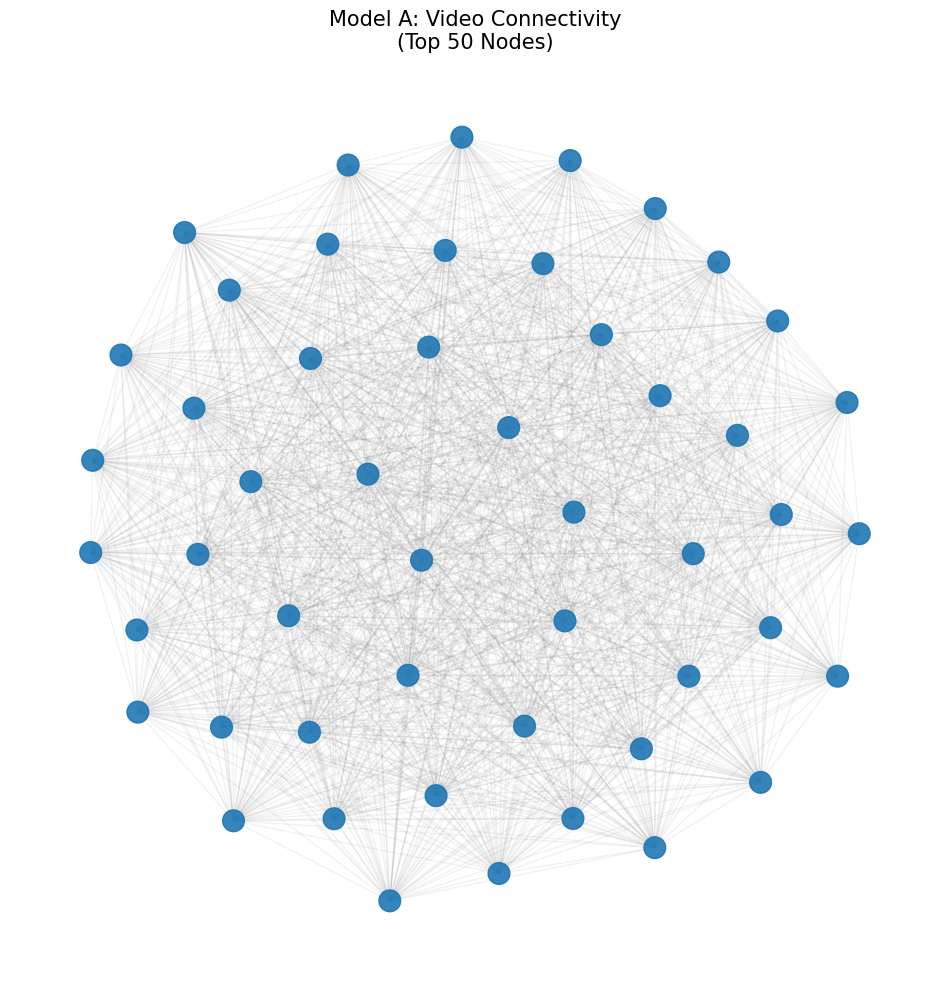

Drawing Model B: Channel-Category Network (The 'Map')...


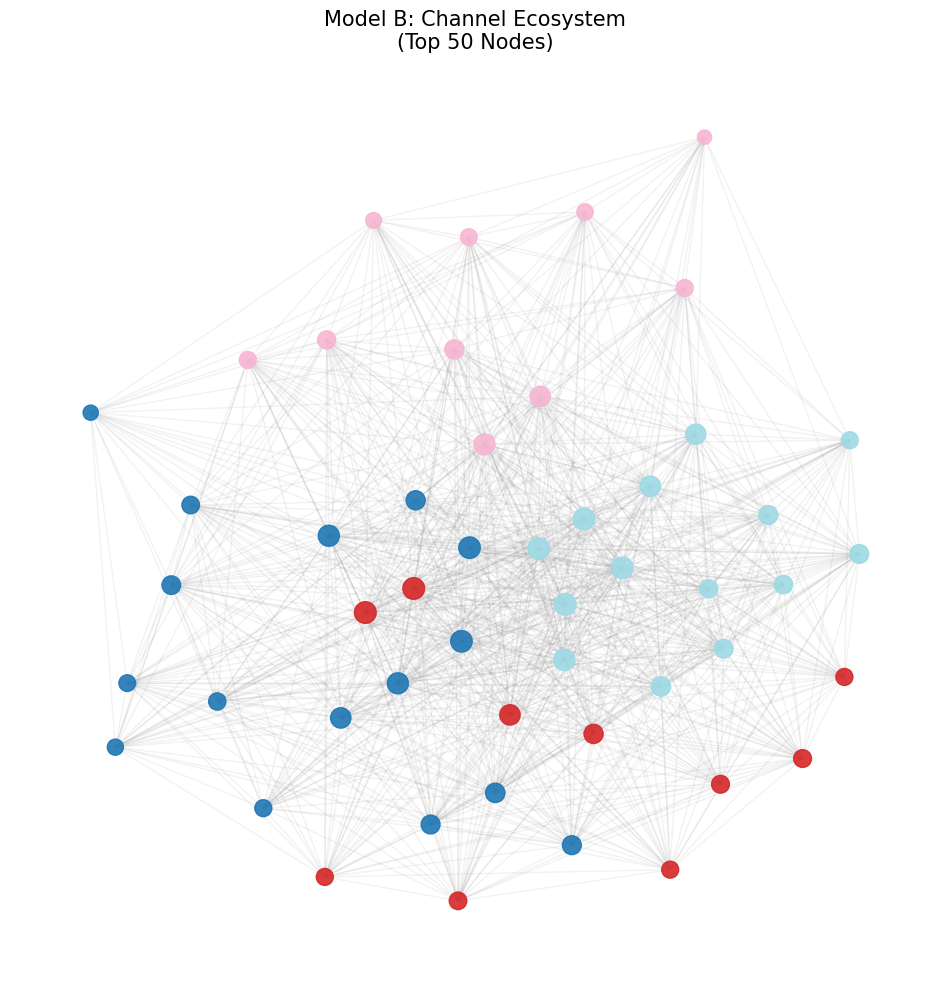

In [52]:
def visualize_network_skeleton(G, title, top_n=200, show_labels=False):
    plt.figure(figsize=(12, 12))

    # 1. FILTER: Keep only the most connected nodes (The "Skeleton")
    # Sort nodes by degree
    sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
    top_nodes = [n for n, d in sorted_nodes[:top_n]]

    # Create the subgraph
    H = G.subgraph(top_nodes)

    # 2. DETECT COMMUNITIES (for coloring)
    # Recalculate partition just for this subgraph view
    partition = community_louvain.best_partition(H)

    # 3. LAYOUT (Force-directed)
    # k controls the spacing between nodes (higher = more spread out)
    pos = nx.spring_layout(H, k=0.15, seed=42)

    # 4. DRAW
    # Nodes
    nx.draw_networkx_nodes(H, pos,
                           node_size=[v * 5 for v in dict(H.degree).values()], # Size by degree
                           cmap=plt.cm.tab20,
                           node_color=list(partition.values()),
                           alpha=0.9)

    # Edges (Make them faint)
    nx.draw_networkx_edges(H, pos, alpha=0.1, edge_color='gray')

    # Labels (Only if requested)
    if show_labels:
        # Only label the very top 20 to avoid clutter
        top_20 = top_nodes[:20]
        labels = {n: n.split(" | ")[0] for n in top_20} # Clean labels for Channels
        nx.draw_networkx_labels(H, pos, labels, font_size=10, font_weight='bold')

    plt.title(f"{title}\n(Top {top_n} Nodes)", fontsize=15)
    plt.axis('off')
    plt.show()

# --- RUN THE VISUALIZATION ---

print("Drawing Model A: Video Network (The 'Hairball')...")
# Video graph is usually messy, no labels needed
visualize_network_skeleton(G, "Model A: Video Connectivity", top_n=50, show_labels=False)

print("Drawing Model B: Channel-Category Network (The 'Map')...")
# Channel graph is cleaner, we WANT to see the names!
if 'G_channels' in locals():
    visualize_network_skeleton(G_channels, "Model B: Channel Ecosystem", top_n=50, show_labels=False)
else:
    print("G_channels not found. Run the 'New Idea' code block first.")

- Same Color = Same Audience Tribe.
- Different Color = Different Audience segments.

Generating L-Curve (Degree Distribution) Comparison...


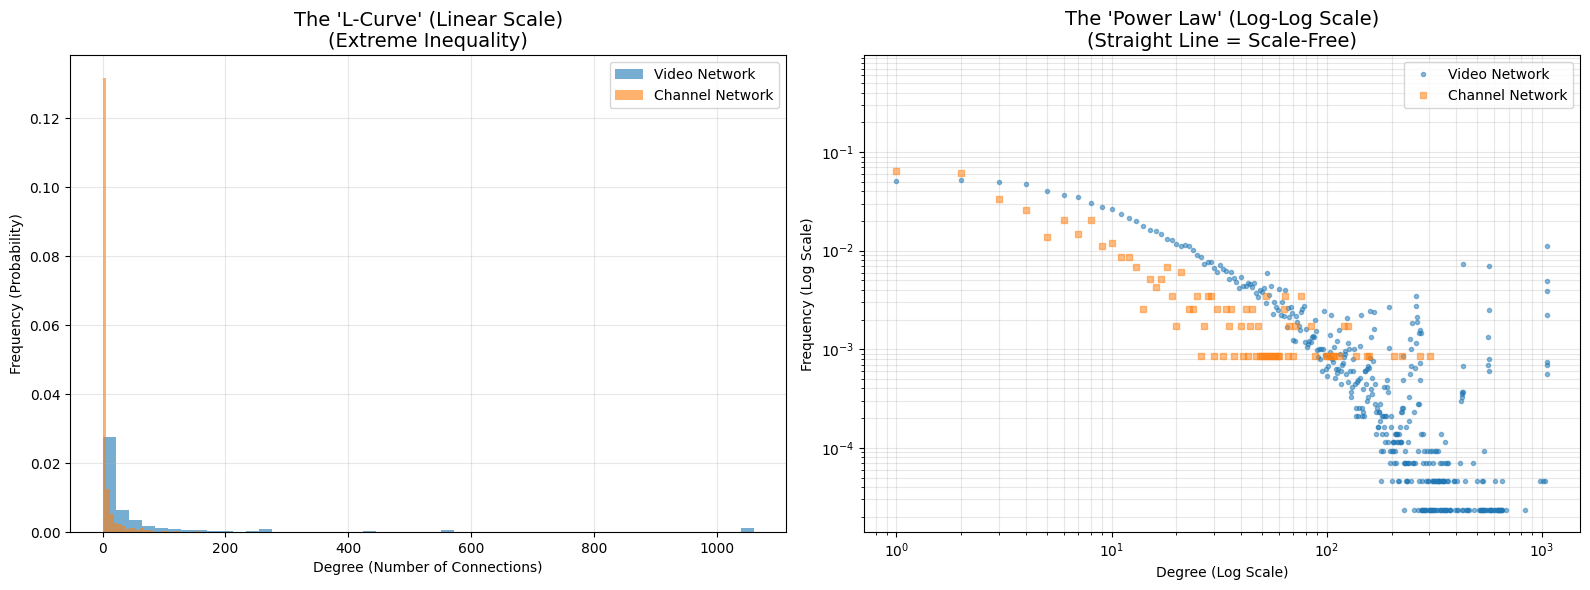


 NETWORK INEQUALITY STATS:
   Max Degree (Video):   1,060 connections (The Viral Hit)
   Max Degree (Channel): 302 connections (The Super-Influencer)
   Avg Degree (Video):   73.3
   Avg Degree (Channel): 7.5


In [42]:
def plot_l_curve_comparison(G_video, G_channel):
    print("Generating L-Curve (Degree Distribution) Comparison...")

    # 1. Get Degrees (Connectivity)
    # -----------------------------
    # List of degrees for every node (e.g., [1, 5, 200, 2, ...])
    degrees_v = [d for n, d in G_video.degree()]
    degrees_c = [d for n, d in G_channel.degree()]

    # 2. Setup the Plot (2 Panels)
    # -----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- PANEL 1: The "L-Curve" (Linear Scale) ---
    # This shows the "Long Tail" explicitly

    # Histogram for Video Network
    axes[0].hist(degrees_v, bins=50, color='#1f77b4', alpha=0.6, label='Video Network', density=True)
    # Histogram for Channel Network
    axes[0].hist(degrees_c, bins=50, color='#ff7f0e', alpha=0.6, label='Channel Network', density=True)

    axes[0].set_title("The 'L-Curve' (Linear Scale)\n(Extreme Inequality)", fontsize=14)
    axes[0].set_xlabel("Degree (Number of Connections)")
    axes[0].set_ylabel("Frequency (Probability)")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # --- PANEL 2: The "Power Law" (Log-Log Scale) ---
    # This checks if it follows the "Rich-get-Richer" rule

    # Helper to calculate PDF (Probability Density Function)
    def get_pdf(data):
        values, counts = np.unique(data, return_counts=True)
        probs = counts / len(data)
        return values, probs

    x_v, y_v = get_pdf(degrees_v)
    x_c, y_c = get_pdf(degrees_c)

    axes[1].loglog(x_v, y_v, 'o', color='#1f77b4', alpha=0.5, markersize=3, label='Video Network')
    axes[1].loglog(x_c, y_c, 's', color='#ff7f0e', alpha=0.5, markersize=4, label='Channel Network')

    axes[1].set_title("The 'Power Law' (Log-Log Scale)\n(Straight Line = Scale-Free)", fontsize=14)
    axes[1].set_xlabel("Degree (Log Scale)")
    axes[1].set_ylabel("Frequency (Log Scale)")
    axes[1].legend()
    axes[1].grid(alpha=0.3, which="both")

    plt.tight_layout()
    plt.show()

    # --- STATS ---
    print("\n NETWORK INEQUALITY STATS:")
    print(f"   Max Degree (Video):   {max(degrees_v):,} connections (The Viral Hit)")
    print(f"   Max Degree (Channel): {max(degrees_c):,} connections (The Super-Influencer)")
    print(f"   Avg Degree (Video):   {np.mean(degrees_v):.1f}")
    print(f"   Avg Degree (Channel): {np.mean(degrees_c):.1f}")

# --- EXECUTE ---
if 'G' in locals() and 'G_channels' in locals():
    plot_l_curve_comparison(G, G_channels)
else:
    print("Please run the graph building steps first.")

Nodes are labeled by their most representative video title because channel names were anonymized/missing in the dataset

Partition not found in G, running simple detection...

REPORT: Video Network (Model A)
• Nodes:                43,132
• Edges:                1,581,204
• Density:              0.001700
• Connected Components: 220
• Giant Component:      40,553 (94.0%)
• Communities Detected: 269


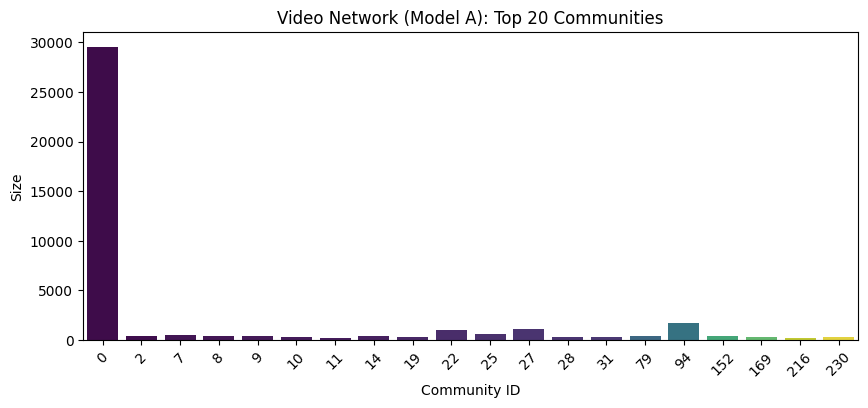


 TOP LANDMARKS (Video Network (Model A))

(Betweenness not calculated, skipping Bridge table)


Calculating metrics for Channel Network (Fast)...

REPORT: Channel Network (Model B)
• Nodes:                1,164
• Edges:                4,362
• Density:              0.006444
• Connected Components: 672
• Giant Component:      493 (42.4%)
• Communities Detected: 678


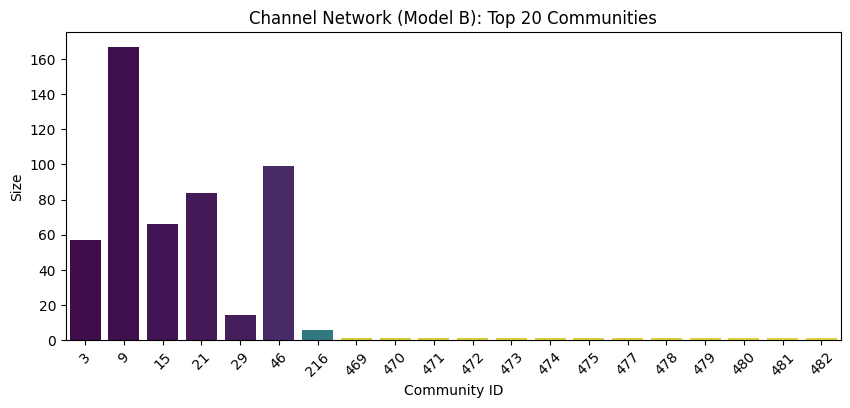


 TOP LANDMARKS (Channel Network (Model B))

TOP 5 BRIDGES (Connectors):


,label,community,betweenness,degree
11,UC-lHJZR3Gqxm24_Vd_AJ5Yw (Gaming),9,0.072248,302
10,UC-lHJZR3Gqxm24_Vd_AJ5Yw (Entertainment),9,0.040997,270
737,UCcgVECVN4OKV6DH1jLkqmcA (People & Blogs),21,0.032945,224
613,UCWwWOFsW68TqXE-HZLC3WIA (People & Blogs),46,0.013001,43
326,UCG8rbF3g2AMX70yOd8vqIZg (Entertainment),21,0.012550,205



TOP 5 CORES (Echo Chambers):


,label,community,clustering,degree
175,UC7eHZXheF8nVOfwB2PEslMw (Comedy),29,0.303510,6
687,UC_vcKmg67vjMP7ciLnSxSHQ (Entertainment),29,0.273714,6
395,UCJi_befq0YDYJ9fCeyHxJbg (Howto & Style),15,0.260956,6
1153,UCzTtkLZFy6wqD4SsA9_fTtw (Howto & Style),15,0.252955,6
344,UCGjylN-4QCpn8XJ1uY-UOgA (Entertainment),216,0.237044,7


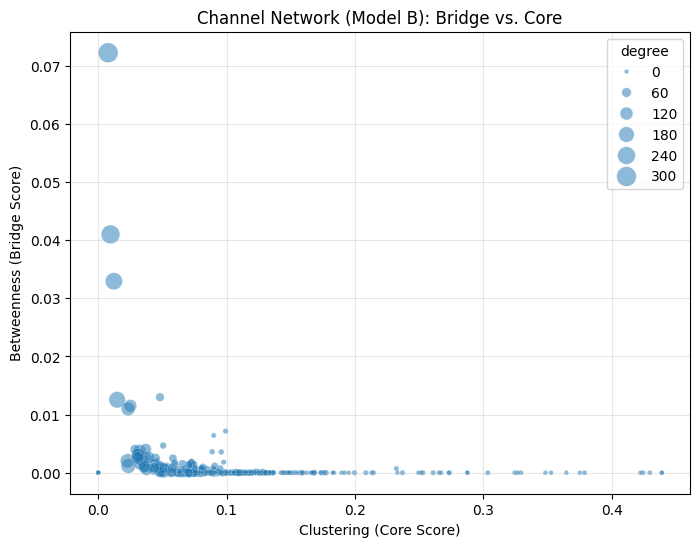

In [ ]:
# --- 1. DEFINE THE REPORT FUNCTION ---
def generate_network_report(G, partition, title="Network Analysis"):
    print(f"\n{'='*60}")
    print(f"REPORT: {title}")
    print(f"{'='*60}")

    # A. GLOBAL STATS
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    components = list(nx.connected_components(G))
    giant_component = len(components[0]) if components else 0

    print(f"• Nodes:                {n_nodes:,}")
    print(f"• Edges:                {n_edges:,}")
    print(f"• Density:              {density:.6f}")
    print(f"• Connected Components: {len(components)}")
    print(f"• Giant Component:      {giant_component:,} ({giant_component/n_nodes:.1%})")

    # B. PREPARE DATA
    # We check if metrics exist in the graph; if not, we use 0
    data = []
    for node in G.nodes():
        # Handle Channel vs Video ID labeling
        label = G.nodes[node].get('label', node)

        data.append({
            'node_id': node,
            'label': label,
            'community': partition.get(node, -1),
            'degree': G.degree(node),
            'clustering': G.nodes[node].get('clustering_coefficient', 0),
            'betweenness': G.nodes[node].get('betweenness', 0)
        })
    df_net = pd.DataFrame(data)

    n_communities = df_net['community'].nunique()
    print(f"• Communities Detected: {n_communities}")

    # C. PLOT 1: Community Sizes
    plt.figure(figsize=(10, 4))
    comm_counts = df_net['community'].value_counts().head(20)
    sns.barplot(x=comm_counts.index, y=comm_counts.values, palette="viridis", hue=comm_counts.index, legend=False)
    plt.title(f"{title}: Top 20 Communities")
    plt.xlabel("Community ID")
    plt.ylabel("Size")
    plt.xticks(rotation=45)
    plt.show()

    # D. LANDMARKS
    print(f"\n TOP LANDMARKS ({title})")

    # Bridges
    if df_net['betweenness'].max() > 0:
        print("\nTOP 5 BRIDGES (Connectors):")
        display(df_net.nlargest(5, 'betweenness')[['label', 'community', 'betweenness', 'degree']])
    else:
        print("\n(Betweenness not calculated, skipping Bridge table)")

    # Cores
    if df_net['clustering'].max() > 0:
        print("\nTOP 5 CORES (Echo Chambers):")
        display(df_net[df_net['degree'] > 5].nlargest(5, 'clustering')[['label', 'community', 'clustering', 'degree']])

    # E. PLOT 2: Hypothesis Check
    if df_net['betweenness'].max() > 0:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df_net, x='clustering', y='betweenness', alpha=0.5, size='degree', sizes=(10, 200))
        plt.title(f"{title}: Bridge vs. Core")
        plt.xlabel("Clustering (Core Score)")
        plt.ylabel("Betweenness (Bridge Score)")
        plt.grid(True, alpha=0.3)
        plt.show()

    return df_net

# --- 2. RUN ON VIDEO NETWORK (G) ---
if 'G' in locals():
    # Attempt to retrieve partition from graph, or recalculate if missing
    # (Assuming you saved 'community' attribute in G)
    part_v = nx.get_node_attributes(G, 'community')
    if not part_v:
        print("Partition not found in G, running simple detection...")
        part_v = community_louvain.best_partition(G)

    df_video_stats = generate_network_report(G, part_v, title="Video Network (Model A)")
else:
    print("G (Video Graph) is not loaded.")

# --- 3. RUN ON CHANNEL NETWORK (G_channels) ---
if 'G_channels' in locals():
    print("\n" + "="*60 + "\n")

    # Since G_channels is small, let's Calculate Metrics on the fly to ensure plots work!
    print("Calculating metrics for Channel Network (Fast)...")
    part_c = community_louvain.best_partition(G_channels)
    bc_c = nx.betweenness_centrality(G_channels, weight='weight')
    cc_c = nx.clustering(G_channels, weight='weight')

    # Store in graph so the function finds them
    nx.set_node_attributes(G_channels, bc_c, 'betweenness')
    nx.set_node_attributes(G_channels, cc_c, 'clustering_coefficient')

    df_channel_stats = generate_network_report(G_channels, part_c, title="Channel Network (Model B)")
else:
    print("G_channels is not loaded. Run the 'New Idea' cells first.")

Generate clickable links:

In [46]:
def list_top_channels_with_links(G_channel, top_k=10):
    print(f"Top {top_k} Channels (Click to Verify):\n")

    # Sort by degree (connectivity) or size
    sorted_nodes = sorted(G_channel.nodes(data=True), key=lambda x: x[1]['size'], reverse=True)[:top_k]

    for node_id, attr in sorted_nodes:
        # Extract the pure Channel ID (remove the "| Category" part if present)
        # If you used the "ID Mode" code, the ID is stored in 'id_only' or is the first part of the string
        c_id = attr.get('id_only', node_id.split(" | ")[0])
        category = attr.get('category', 'Unknown')

        url = f"https://www.youtube.com/channel/{c_id}"

        print(f"{attr.get('label', node_id)}")
        print(f"   Category: {category}")
        print(f"   Link: {url}")
        print("-" * 50)

# --- RUN IT ---
if 'G_channels' in locals():
    list_top_channels_with_links(G_channels)

Top 10 Channels (Click to Verify):

UC-lHJZR3Gqxm24_Vd_AJ5Yw (Gaming)
   Category: Gaming
   Link: https://www.youtube.com/channel/UC-lHJZR3Gqxm24_Vd_AJ5Yw
--------------------------------------------------
UC-lHJZR3Gqxm24_Vd_AJ5Yw (Entertainment)
   Category: Entertainment
   Link: https://www.youtube.com/channel/UC-lHJZR3Gqxm24_Vd_AJ5Yw
--------------------------------------------------
UCcgVECVN4OKV6DH1jLkqmcA (People & Blogs)
   Category: People & Blogs
   Link: https://www.youtube.com/channel/UCcgVECVN4OKV6DH1jLkqmcA
--------------------------------------------------
UCG8rbF3g2AMX70yOd8vqIZg (Entertainment)
   Category: Entertainment
   Link: https://www.youtube.com/channel/UCG8rbF3g2AMX70yOd8vqIZg
--------------------------------------------------
UCS5Oz6CHmeoF7vSad0qqXfw (Gaming)
   Category: Gaming
   Link: https://www.youtube.com/channel/UCS5Oz6CHmeoF7vSad0qqXfw
--------------------------------------------------
UC7TTtOQKMXTWWMtWQMIgVSA (Entertainment)
   Category: Entertainme

In [ ]:
def benchmark_methods(df, n_rows=100_000):
    print(f"STARTING BENCHMARK on first {n_rows:,} rows...\n")

    # 1. PREPARE DATA SAMPLE
    # ----------------------
    df_sample = df.head(n_rows)[['author_id', 'video_id']].drop_duplicates().copy()
    print(f"   Sample size: {len(df_sample):,} rows")
    print(f"   Unique Users: {df_sample['author_id'].nunique():,}")
    print(f"   Unique Videos: {df_sample['video_id'].nunique():,}")
    print("-" * 50)

    # =========================================================
    # METHOD 1: YOUR INITIAL IMPLEMENTATION (Iterative Loops)
    # =========================================================
    print("METHOD 1: Iterative Loop (Your Code)...")
    start_1 = time.time()

    # A. Build User->Video Mapping
    user_to_videos = df_sample.groupby('author_id')['video_id'].apply(list).to_dict()

    # B. Compute Edges (The Bottleneck)
    edge_overlaps = defaultdict(int)
    for user, vids in user_to_videos.items():
        if len(vids) >= 2:
            # This 'combinations' step has complexity O(N^2) per user
            for v1, v2 in combinations(sorted(vids), 2):
                edge_overlaps[(v1, v2)] += 1

    # C. Build DataFrame (to match your output format)
    edge_list_1 = [{'source': k[0], 'target': k[1], 'weight': v} for k, v in edge_overlaps.items()]
    df_edges_1 = pd.DataFrame(edge_list_1)

    time_1 = time.time() - start_1
    print(f"   Time: {time_1:.4f} seconds")
    print(f"   edges found: {len(df_edges_1):,}")

    # =========================================================
    # METHOD 2: MATRIX MULTIPLICATION (Linear Algebra)
    # =========================================================
    print("\n METHOD 2: Sparse Matrix Multiplication...")
    start_2 = time.time()

    # A. Map IDs to Integers
    users = df_sample['author_id'].unique()
    videos = df_sample['video_id'].unique()

    user_map = {u: i for i, u in enumerate(users)}
    video_map = {v: i for i, v in enumerate(videos)}

    # B. Create Sparse Matrix (Users x Videos)
    row_ind = df_sample['author_id'].map(user_map).values
    col_ind = df_sample['video_id'].map(video_map).values
    data = np.ones(len(df_sample), dtype=int)

    # Shape: (Rows=Users, Cols=Videos)
    M = sp.csr_matrix((data, (row_ind, col_ind)), shape=(len(users), len(videos)))

    # C. The Magic Trick: M.T * M = (Video x User) * (User x Video) = Video x Video
    # This computes ALL shared counts in one step
    V = M.T @ M

    # D. Extract Edges
    # Remove self-loops (diagonal)
    V.setdiag(0)
    V.eliminate_zeros()

    # Get upper triangle only (to avoid duplicates A-B and B-A)
    V_tri = sp.triu(V)

    # Convert to standard format
    rows, cols = V_tri.nonzero()
    weights = V_tri.data

    # (Optional: map back to string IDs - included for fair comparison)
    # reverse_video_map = {i: v for v, i in video_map.items()}
    # source_ids = [reverse_video_map[r] for r in rows]
    # target_ids = [reverse_video_map[c] for c in cols]

    time_2 = time.time() - start_2
    print(f"   Time: {time_2:.4f} seconds")
    print(f"   edges found: {len(weights):,}")

    # =========================================================
    # RESULTS
    # =========================================================
    print("\n" + "="*50)
    print("FINAL VERDICT")
    print("="*50)

    if time_2 > 0:
        speedup = time_1 / time_2
        print(f"Matrix Method is {speedup:.1f}x FASTER")
    else:
        print("Matrix Method was too fast to measure.")

    print(f"\nWhy? Method 1 complexity is O(Users * VideosPerUser^2)")
    print(f"If a user watched 50 videos:")
    print(f"   - Method 1 runs a loop 1,225 times (50*49/2)")
    print(f"   - Method 2 does this in highly optimized C-code.")

# --- EXECUTE ---
if 'df' in locals():
    # Ensure columns match your dataset (rename if needed)
    # df.rename(columns={'author': 'author_id'}, inplace=True)
    benchmark_methods(df, n_rows=100_000)
else:
    print("Please load your 'df' dataframe first.")

🏁 STARTING BENCHMARK on first 100,000 rows...

   Sample size: 57,072 rows
   Unique Users: 3,474
   Unique Videos: 26,648
--------------------------------------------------
🐢 METHOD 1: Iterative Loop (Your Code)...
   ⏱️ Time: 9.0592 seconds
   edges found: 1,523,168

🚀 METHOD 2: Sparse Matrix Multiplication...
   ⏱️ Time: 0.1973 seconds
   edges found: 1,523,168

🏆 FINAL VERDICT
Matrix Method is 45.9x FASTER

Why? Method 1 complexity is O(Users * VideosPerUser^2)
If a user watched 50 videos:
   - Method 1 runs a loop 1,225 times (50*49/2)
   - Method 2 does this in highly optimized C-code.


## Data analysis on the graph

### 1. The Macro View: Which "Continents" (Categories) interact? (e.g., "Do Gamers watch News?")
E.G. The Story: "First, we zoomed out to see how the major interest groups interact. We discovered that the 'Gaming' community is highly isolated, while 'Music' acts as a universal language connecting everyone."

A Heatmap of cross-category traffic:
- **Interpretation:**
  - Bright Squares off-diagonal: Strong connections (e.g., if Gaming intersects Tech, that square will be bright).
  - Dark Zones: Segregation (e.g., Politics might not touch Gaming).

The Category Interaction Matrix:


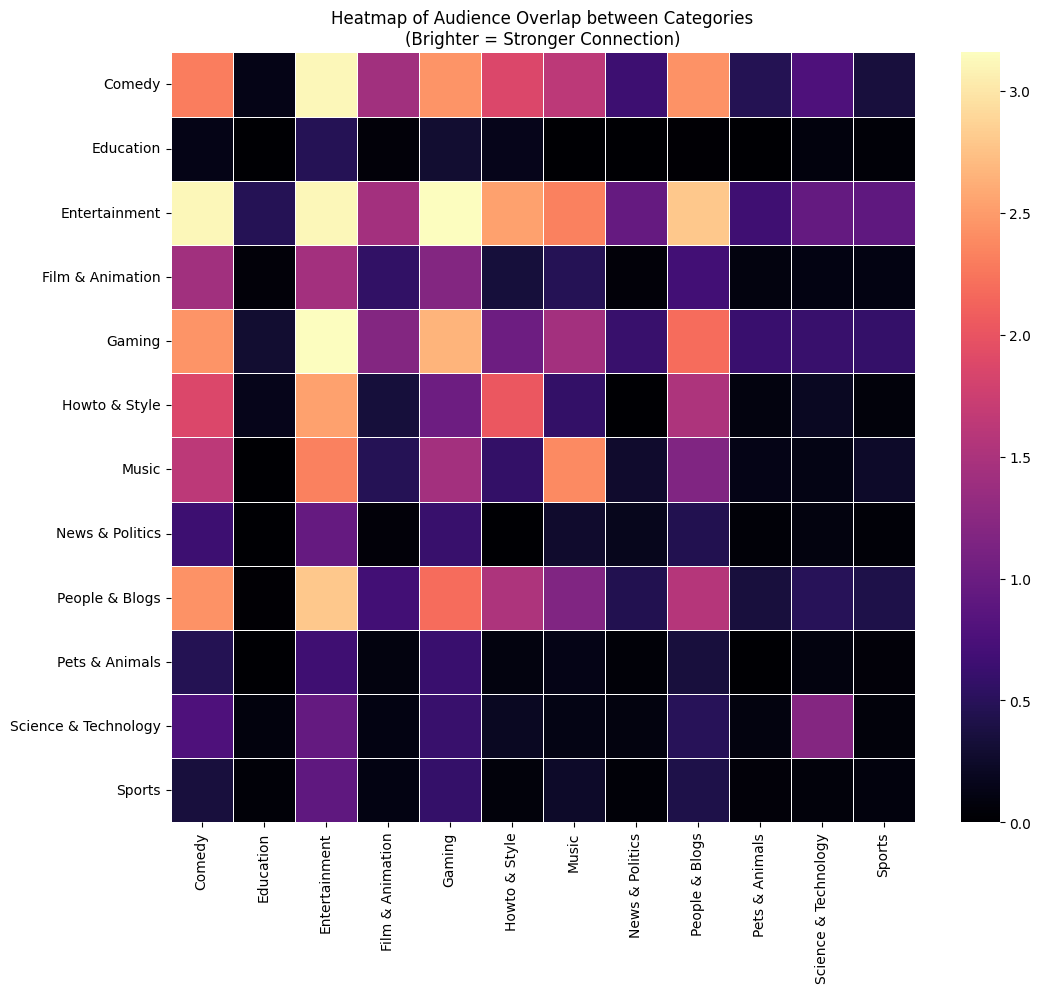

In [ ]:
def analyze_category_flow(G_channel):
    print("The Category Interaction Matrix:")

    # 1. Aggregation: Sum weights between categories
    category_interaction = {}

    for u, v, data in G_channel.edges(data=True):
        cat_u = G_channel.nodes[u].get('category', 'Unknown')
        cat_v = G_channel.nodes[v].get('category', 'Unknown')

        # Sort to ensure A-B is same as B-A
        pair = tuple(sorted([cat_u, cat_v]))
        weight = data.get('weight', 0)

        if pair not in category_interaction:
            category_interaction[pair] = 0
        category_interaction[pair] += weight

    # 2. Convert to DataFrame for Heatmap
    # We list all unique categories
    categories = sorted(list(set([c for pair in category_interaction.keys() for c in pair])))
    matrix = pd.DataFrame(0.0, index=categories, columns=categories)

    for (c1, c2), w in category_interaction.items():
        matrix.loc[c1, c2] = w
        matrix.loc[c2, c1] = w # Symmetric

    # Normalize by diagonal (Self-loop) to see relative strength?
    # Or just log scale. Let's use Log scale for visibility.
    import numpy as np
    matrix_log = np.log1p(matrix)

    # 3. Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix_log, annot=False, cmap="magma", linewidths=.5)
    plt.title("Heatmap of Audience Overlap between Categories\n(Brighter = Stronger Connection)")
    plt.show()

    return matrix

# --- RUN IT ---
if 'G_channels' in locals():
    cat_matrix = analyze_category_flow(G_channels)

Some considerations about the heatmap:
- The diagonal represents Intra-Category Connectivity (e.g., How much do Gamers watch other Gaming channels?):

  - Bright Diagonal (High Value): This indicates an "Echo Chamber" or a very tight community. (loyal = bright)
  - Dim/Dark Diagonal (Low Value): This indicates a "Loose Category". (dark = more explorer, not loyal)


- Different Colors: The color scale is also affected by Size. If "Music" has 10,000 channels and "Pets" has 100, "Music" will naturally have a brighter sum.

### 2. Category Backbone Network
Instead of plotting 1,000 channels, we can compress the entire graph into just ~15 nodes (one per Category). We draw a line only if there is significant audience overlap.

Generating Chapter 1.5: The 'Continent Map' (Category Backbone)...


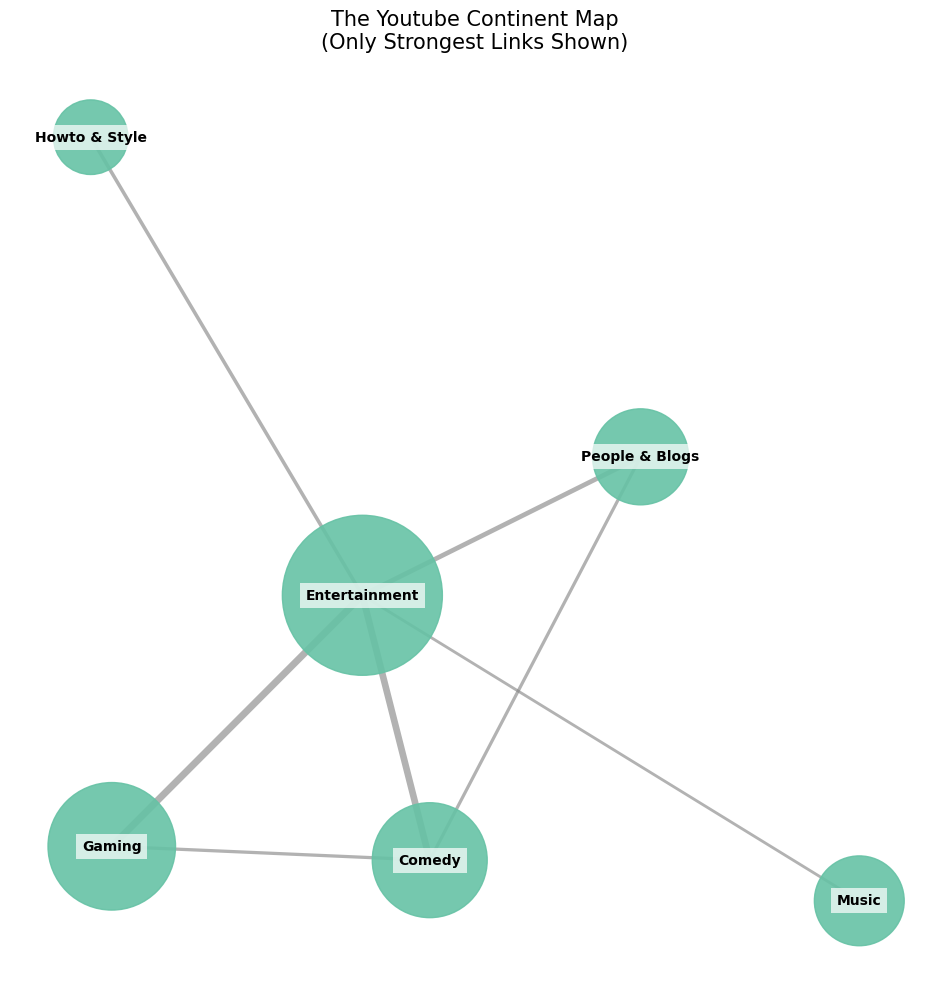

In [ ]:
def plot_category_backbone(G_channel, threshold_percentile=70):
    print("Generating Chapter 1.5: The 'Continent Map' (Category Backbone)...")

    # 1. BUILD THE CATEGORY GRAPH
    # Create a new graph where Nodes = Categories
    G_cat = nx.Graph()

    # Tally up weights between categories
    edge_weights = {}
    node_sizes = {}

    for u, v, data in G_channel.edges(data=True):
        cat_u = G_channel.nodes[u].get('category', 'Unknown')
        cat_v = G_channel.nodes[v].get('category', 'Unknown')

        # Count node sizes (how many channels per category)
        node_sizes[cat_u] = node_sizes.get(cat_u, 0) + 1
        node_sizes[cat_v] = node_sizes.get(cat_v, 0) + 1

        # Skip self-loops for the map (we want to see connections BETWEEN types)
        if cat_u != cat_v:
            pair = tuple(sorted([cat_u, cat_v]))
            w = data.get('weight', 0)
            edge_weights[pair] = edge_weights.get(pair, 0) + w

    # 2. ADD TO GRAPH
    # Normalize weights so the plot isn't messy
    max_w = max(edge_weights.values()) if edge_weights else 1

    # Filter: Only keep the STRONGEST links (e.g., top 30%) to make it "Explicit"
    import numpy as np
    cutoff = np.percentile(list(edge_weights.values()), threshold_percentile)

    for (c1, c2), w in edge_weights.items():
        if w > cutoff:
            G_cat.add_edge(c1, c2, weight=w, penwidth=(w/max_w)*5)

    # Add nodes (even if isolated)
    for cat in node_sizes:
        if cat in G_cat.nodes(): # Only if connected or force add
            G_cat.nodes[cat]['size'] = node_sizes[cat]

    # 3. VISUALIZE
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G_cat, k=2.0, seed=42) # k=2 pushes them apart

    # Draw Nodes
    sizes = [node_sizes.get(n, 10)*5 for n in G_cat.nodes()]
    nx.draw_networkx_nodes(G_cat, pos, node_size=sizes, node_color="#66c2a5", alpha=0.9)

    # Draw Edges (Thicker = Stronger connection)
    weights = [G_cat[u][v]['penwidth'] for u, v in G_cat.edges()]
    nx.draw_networkx_edges(G_cat, pos, width=weights, edge_color="gray", alpha=0.6)

    # Draw Labels
    nx.draw_networkx_labels(G_cat, pos, font_size=10, font_weight="bold",
                            bbox=dict(facecolor="white", edgecolor='none', alpha=0.7))

    plt.title("The Youtube Continent Map\n(Only Strongest Links Shown)", fontsize=15)
    plt.axis('off')
    plt.show()

# --- RUN IT ---
if 'G_channels' in locals():
    plot_category_backbone(G_channels, threshold_percentile=90)
    # Try changing threshold (50, 80, 90) to see more/less lines!

### 3. Bridge Analysis
E.G. The Story: "We then looked for the 'Diplomats'—the channels that sit on the borders. While 'PewDiePie' is the King of Gaming, we found that [Channel X] is actually the critical bridge connecting Gamers to the Science community."

A list of channels with high Betweenness Centrality that connect different categories:

In [58]:
def find_the_diplomats(G_channel, top_k=5):
    print(f"The Bridges between Categories...")

    # Calculate Betweenness (How much traffic flows THROUGH this node)
    # limit to k items to speed up approximation if graph is huge, or run full if < 2000 nodes
    betweenness = nx.betweenness_centrality(G_channel, weight='weight')

    # Sort
    sorted_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)

    print(f"\n Top {top_k} Channels that act as Bridges:")
    print(f"{'Channel Name':<40} | {'Category':<15} | {'Bridge Score':<10} | {'Top Neighbor Types'}")
    print("-" * 100)

    for node_id, score in sorted_nodes[:top_k]:
        # Get Attributes
        label = G_channel.nodes[node_id].get('label', node_id)
        my_cat = G_channel.nodes[node_id].get('category', 'Unknown')

        # Analyze Neighbors: Who are they connecting?
        neighbors = G_channel[node_id]
        neighbor_cats = [G_channel.nodes[n].get('category') for n in neighbors]

        # Find the most common OUTSIDE category
        from collections import Counter
        counts = Counter([c for c in neighbor_cats if c != my_cat])

        if counts:
            primary_bridge = f"Links to {counts.most_common(1)[0][0]}"
        else:
            primary_bridge = "Internal Hub (Echo Chamber)"

        print(f"{label[:38]:<40} | {my_cat[:13]:<15} | {score:.4f}     | {primary_bridge}")

# --- RUN IT ---
if 'G_channels' in locals():
    find_the_diplomats(G_channels, top_k=10)

The Bridges between Categories...

 Top 10 Channels that act as Bridges:
Channel Name                             | Category        | Bridge Score | Top Neighbor Types
----------------------------------------------------------------------------------------------------
UC-lHJZR3Gqxm24_Vd_AJ5Yw (Gaming)        | Gaming          | 0.0722     | Links to Entertainment
UC-lHJZR3Gqxm24_Vd_AJ5Yw (Entertainmen   | Entertainment   | 0.0410     | Links to Music
UCcgVECVN4OKV6DH1jLkqmcA (People & Blo   | People & Blog   | 0.0329     | Links to Entertainment
UCWwWOFsW68TqXE-HZLC3WIA (People & Blo   | People & Blog   | 0.0130     | Links to Entertainment
UCG8rbF3g2AMX70yOd8vqIZg (Entertainmen   | Entertainment   | 0.0125     | Links to Gaming
UC7TTtOQKMXTWWMtWQMIgVSA (Entertainmen   | Entertainment   | 0.0115     | Links to Gaming
UCS5Oz6CHmeoF7vSad0qqXfw (Gaming)        | Gaming          | 0.0110     | Links to Entertainment
UCq-Fj5jknLsUf-MWSy4_brA (Music)         | Music           | 0.0071     | 

### 4. Recommendation simulation
E.G. The Story: "Finally, we applied this logic to a user. Starting from a 'Music' preference, our algorithm uses the 'Diplomat' nodes to guide them toward 'Entertainment', broadening their horizon without losing relevance."

A step-by-step path trace:

In [60]:
def simulate_user_journey(G_channel, start_node_search_term):
    print("\n The Recommendation Journey:")

    # 1. Find a start node based on search string (e.g., "Music")
    candidates = [n for n in G_channel.nodes() if start_node_search_term.lower() in str(G_channel.nodes[n].get('label', '')).lower()]

    if not candidates:
        print(f"No channel found matching '{start_node_search_term}'")
        return

    start_node = candidates[0]
    start_label = G_channel.nodes[start_node].get('label')
    start_cat = G_channel.nodes[start_node].get('category')

    print(f"START POINT: User is watching '{start_label}' ({start_cat})")

    # 2. Step 1: Immediate Neighbors (The "Safe" Choice)
    neighbors = sorted(G_channel[start_node].items(), key=lambda x: x[1]['weight'], reverse=True)
    if not neighbors: return

    safe_choice = neighbors[0][0]
    safe_label = G_channel.nodes[safe_choice].get('label')

    print(f"   ")
    print(f"   SAFE Recommendation: '{safe_label}' (Same Community)")

    # 3. Step 2: The "Diplomat" Jump (The "Novel" Choice)
    # Look for a neighbor that is in a DIFFERENT category but high weight
    novel_choice = None
    for n, data in neighbors:
        cat = G_channel.nodes[n].get('category')
        if cat != start_cat:
            novel_choice = n
            break

    if novel_choice:
        novel_label = G_channel.nodes[novel_choice].get('label')
        novel_cat = G_channel.nodes[novel_choice].get('category')
        print(f"   ")
        print(f"   DISCOVERY Recommendation: '{novel_label}'")
        print(f"      (Why? It connects {start_cat} to {novel_cat})")
    else:
        print("   (No cross-category bridge found from here)")

# --- RUN IT ---
# Try searching for a word you know exists in your labels, e.g., "Gaming" or "Music" or a specific name
if 'G_channels' in locals():
    # Replace 'Music' with a keyword likely to be in your new readable labels!
    simulate_user_journey(G_channels, "Music")
    simulate_user_journey(G_channels, "Gaming")


 The Recommendation Journey:
START POINT: User is watching 'UC-8Q-hLdECwQmaWNwXitYDw (Music)' (Music)
   
   SAFE Recommendation: 'UCANLZYMidaCbLQFWXBC95Jg (Music)' (Same Community)
   
   DISCOVERY Recommendation: 'UC0v-tlzsn0QZwJnkiaUSJVQ (Entertainment)'
      (Why? It connects Music to Entertainment)

 The Recommendation Journey:
START POINT: User is watching 'UC-BG8jc9gI_BpobNXldQuFw (Gaming)' (Gaming)
